In [4]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(0)

from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill
from export_to_xlsx import save_opening_output_file, set_predicted_in_xls

#Загрузка данных

In [5]:
#удаляем выбросы
def remove_row_emissions(data, row_name):
    print("remove emissions ", row_name)
    lower_bound = data[row_name].quantile(q=0.025)
    upper_bound = data[row_name].quantile(q=0.975)
    #print(data)
    data[(data[row_name] < lower_bound) | (data[row_name] > upper_bound)] = np.nan
    data.dropna(subset=[row_name], inplace=True)

# разделяем регионы, которые сильно расходятся в ценовой политике
def split_df_into_price_region(df):
    high = [78, 77]
    middle = [50]
    df_high_price = df[df["Регион"].isin(set(high))].copy()

    df_middle_price = df[
        (((df["Жителей в нп"] > 1000000) & (df["Жителей в нп"] < 5000000)) | (df["Регион"].isin(set(middle)))) & ~(
            df["Регион"].isin(set(high)))].copy()
    df_low_price = df[
        (df["Жителей в нп"] <= 1000000) & (df["Жителей в нп"] >= 100) & ~(
            df["Регион"].isin(set(high + middle)))].copy()
    return df_high_price, df_middle_price, df_low_price

In [6]:
def loading_data(paths):
    numeric_features = ["Жителей", "Жителей в нп", "Коммерческих объектов", "Общая площадь",
                        "Отдельный вход", "Культурное наследие", "Ремонт", "Этаж"]
    df = pd.DataFrame()
    if type(paths) == list:
        for path in paths:
            df = pd.concat((df, pd.read_excel(path),), axis=0)
    else:
        df = pd.read_excel(paths)

    df['Тип объекта'] = df['Тип объекта'].astype("string")

    for name in numeric_features:
        df[name].replace('None', 0, inplace=True)
        df[name].replace(np.nan, 0, inplace=True)

    df['Жителей в нп'] = df['Жителей в нп'].astype(int)
    df.dropna(subset=['Жителей','Жителей в нп'], inplace=True)

    return df

In [3]:
target = "Цена за кв.м"
numeric_features = ["Жителей", "Коммерческих объектов", "Расстояние до почты", "Общая площадь"]
categorical_features = ["Регион", "Форма проведения", "Имущество", "Этаж"]
columns = [target] +numeric_features + categorical_features

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 10)

#смотрим в каких регионах сильный разброс цены за кв.м
full_df.boxplot(by ='Регион', column =[target], grid = False, figsize=(20,10))

NameError: name 'full_df' is not defined

In [4]:
#убираем их из обучения, так как для них нужно обучать свою модель
#разделяем регионы, которые сильно расходятся в ценовой политике
def split_df_into_price_region(df):
    high = [78,77]
    middle = [2,16,50,59,47]
    df_high_price = df[df["Регион"].isin(set(high))].copy()
    df_middle_price = df[df["Регион"].isin(set(middle))].copy()
    df_low_price = df[~df["Регион"].isin(set(middle+high))].copy()
    
    return df_high_price, df_middle_price, df_low_price
    
#df = df[~df["Регион"].isin(set([78,77]))]
df_high, df_middle, df_low = split_df_into_price_region(full_df)

df_high.corrwith(df_high[target])

Unnamed: 0               0.355134
Регион                  -0.091267
Общая площадь           -0.477058
Цена                     0.161472
Цена за кв.м             1.000000
H3 чел/кв.м              0.423468
Чел/кв.м                 0.528406
Ком/кв.м                 0.392558
Коммерческих объектов    0.119559
Расстояние до почты     -0.066687
Этаж                     0.224770
Предсказываемая               NaN
Разница с реальной            NaN
Жителей                  0.091712
dtype: float64

<AxesSubplot:>

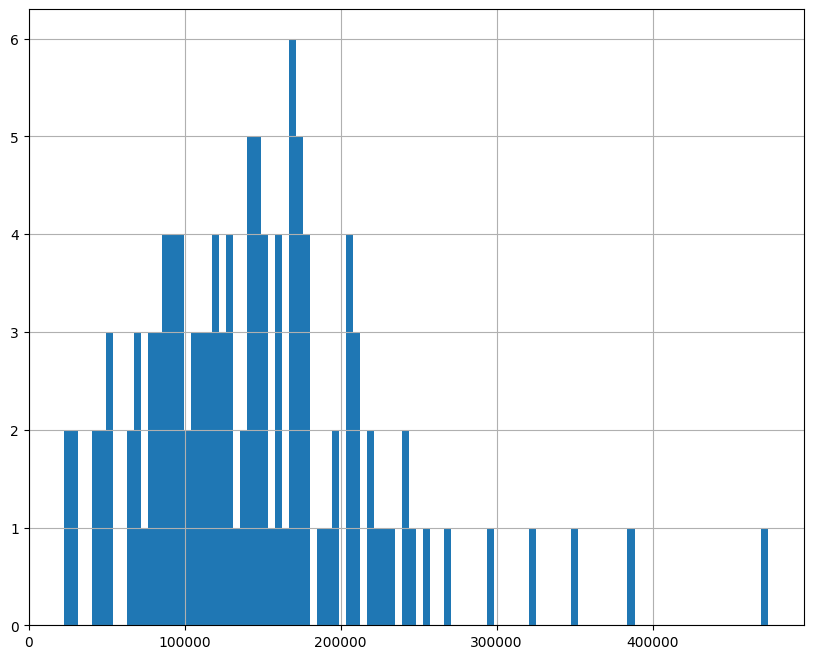

In [5]:
df_high[target].hist(bins=100, figsize=(10,8))

<AxesSubplot:>

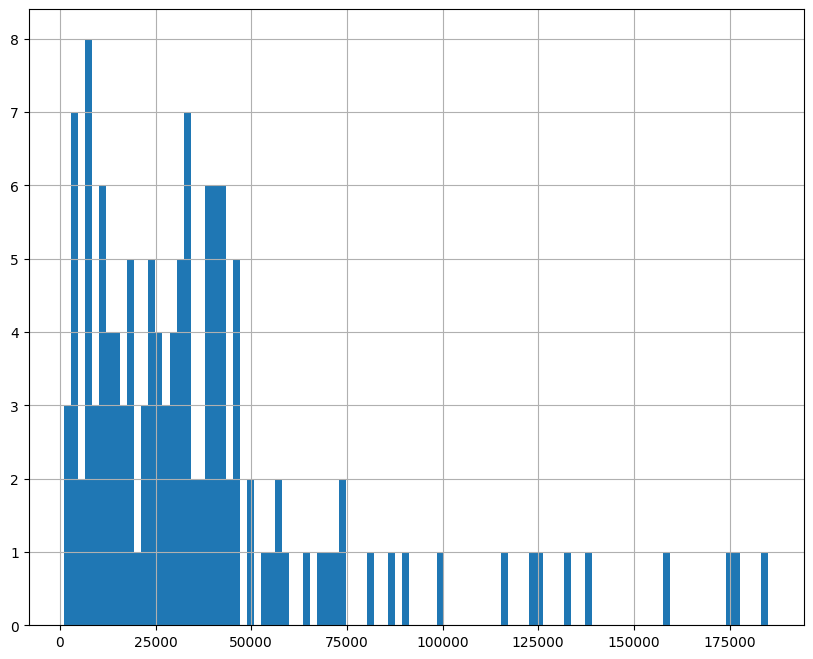

In [6]:
df_middle[target].hist(bins=100, figsize=(10,8))

<AxesSubplot:>

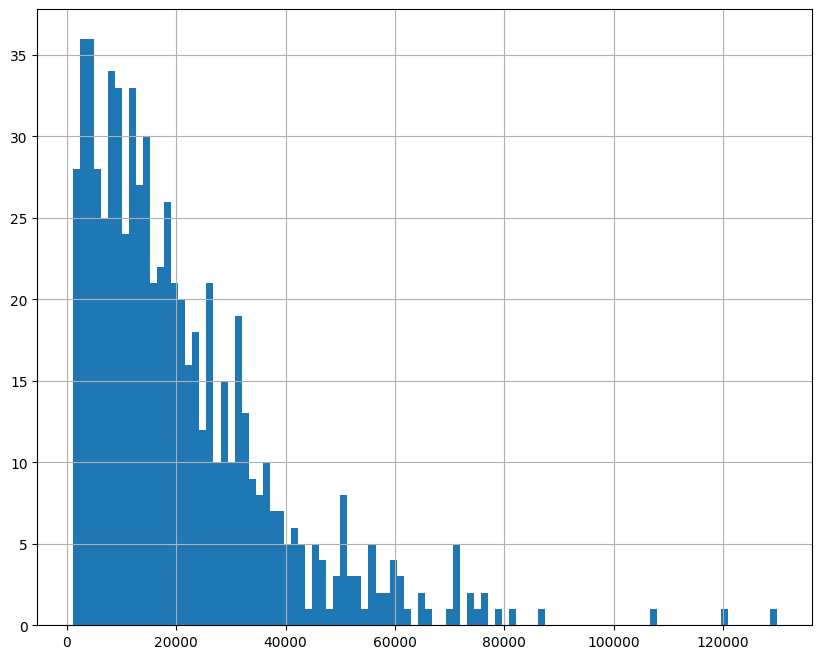

In [7]:
df_low[target].hist(bins=100, figsize=(10,8))

In [8]:
#удаляем выбросы
def remove_row_emissions(data, row_name):
    print("remove emissions ", row_name)
    lower_bound = data[row_name].quantile(q=0.025)
    upper_bound = data[row_name].quantile(q=0.975)
    #print(data)
    data[(data[row_name] < lower_bound) | (data[row_name] > upper_bound)] = np.nan
    data.dropna(subset=[row_name], inplace=True)

remove_row_emissions(df_high, "Цена за кв.м")
remove_row_emissions(df_middle, "Цена за кв.м")
remove_row_emissions(df_low, "Цена за кв.м")
#remove_row_emissions(df, "Общая площадь")

remove emissions  Цена за кв.м
remove emissions  Цена за кв.м
remove emissions  Цена за кв.м


In [25]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='median')), ("scaler", MinMaxScaler())]
)
#SimpleImputer(strategy='constant', fill_value=1)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [ ]:
#Ridge(alpha=10)
    #model train score: 0.367
    #model test score: 0.300
    #MAE: 10674.231

#KNeighborsRegressor(8)
    #model train score: 0.405
    #model test score: 0.305
    #MAE: 10418.642
#DecisionTreeRegressor(max_depth=4)
    #model train score: 0.435
    #model test score: 0.121
    #MAE: 11433.182

In [42]:

clf_h = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Ridge(alpha=10))]
)

df_test_h, df_test_m, df_test_l = split_df_into_price_region(loading_data('../torgi/output_test.xlsx'))

#тренируем модель
y_h = df_high["Цена за кв.м"].values
X_h = df_high[numeric_features + categorical_features]
clf_h.fit(X_h, y_h)

y_test_h = df_test_h["Цена за кв.м"].values
X_test_h = df_test_h[numeric_features + categorical_features]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# clf.fit(X_train, y_train)

In [43]:
#Для модели не достаточно данных для обучения, что бы научится адекватно предсказывать цену в этих регионах
print("model train score: %.3f" % clf_h.score(X_h, y_h))
print("model test score: %.3f" % clf_h.score(X_test_h, y_test_h))
print("MAE train: %.3f" % mean_absolute_error(y_h, clf_h.predict(X_h)))
print("MAE test: %.3f" % mean_absolute_error(y_test_h, clf_h.predict(X_test_h)))


model train score: 0.476
model test score: -1.004
MAE: 57184.749
MAE: 33539.147


In [61]:
clf_m = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor(max_depth=4))]
)

y_m = df_middle["Цена за кв.м"].values
X_m = df_middle[numeric_features + categorical_features]
clf_m.fit(X_m, y_m)

#print(X)
#df_test = loading_data('../torgi/output_test.xlsx')
#df_test = df_test[~df_test["Регион"].isin(set([78,77]))]
#remove_row_emissions(df_test, "Цена за кв.м")

y_test_m = df_test_m["Цена за кв.м"].values
X_test_m = df_test_m[numeric_features + categorical_features]

print("model train score: %.3f" % clf_m.score(X_m, y_m))
print("model test score: %.3f" % clf_m.score(X_test_m, y_test_m))
print("MAE: %.3f" % mean_absolute_error(y_test_m, clf_m.predict(X_test_m)))

#очень сильные результаты можно на них упираться при принятии решения

model train score: 0.825
model test score: 0.847
MAE: 7009.698


In [64]:
clf_l = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor(max_depth=4))]
)

y_l = df_low["Цена за кв.м"].values
X_l = df_low[numeric_features + categorical_features]

clf_l.fit(X_l, y_l)

y_test_l = df_test_l["Цена за кв.м"].values
X_test_l = df_test_l[numeric_features + categorical_features]


print("model train score: %.3f" % clf_l.score(X_l, y_l))
print("model test score: %.3f" % clf_l.score(X_test_l, y_test_l))
print("MAE: %.3f" % mean_absolute_error(y_test_l, clf_l.predict(X_test_l)))

model train score: 0.424
model test score: 0.505
MAE: 13892.310


In [58]:
#смотрим результаты
df_test_h['predicted'] = clf_h.predict(df_test_h[numeric_features+categorical_features])

#очень большой разброс, которым нельзя доверять
set_predicted_in_xls("../torgi/output_test.xlsx", df_test_h)
df_test_h

set_predicted_in_xls


,Unnamed: 0,Регион,Общая площадь,id,Название,...,Этаж,Unnamed: 22,Unnamed: 23,Жителей,predicted
44,44,77,378.4,NaN,В соответствии с Извещением.,...,0.0,NaN,NaN,14560.0,94371.502739
45,45,77,17.8,NaN,"Продажа нежилого помещения, находящегося в хозяйственном ведении Государственного унитарного предприятия города Москвы «Центр управления городским имуществом» (ГУП «ЦУГИ»), расположенного по адресу: г. Москва, Строгино, ул. Лыковская 2-я, вл. 23, корп. 1, пом. XIII (нежилое помещение общей площадью 17,8 кв. м), кадастровый номер 77:08:0013010:1203",...,0.0,NaN,NaN,7337.0,108200.775093
46,46,77,181.5,NaN,"Продажа имущества, находящегося в собственности города Москвы, нежилое помещение по адресу: г. Москва, пр. Петровско-Разумовский, д. 16, площадью 181,5 кв. м, кадастровый номер: 77:09:0004011:6556, посредством публичного предложения.",...,0.0,NaN,NaN,16854.0,69021.383095
47,47,77,152.2,NaN,"Продажа имущества, находящегося в собственности города Москвы, нежилое помещение по адресу: г. Москва, ул. Мытная, д. 25, корп. 1, общей площадью 152,2 кв. м, кадастровый номер: 77:01:0006007:3888 посредством публичного предложения",...,0.0,NaN,NaN,11418.0,78576.231225
48,48,77,60.4,NaN,"Продажа нежилых помещений, находящихся в хозяйственном ведении Государственного унитарного предприятия города Москвы «Центр управления городским имуществом» (ГУП «ЦУГИ»), расположенных по адресу: город Москва, внутригородская территория муниципальный округ Войковский, Ленинградское шоссе, дом 8, корпус 3, площадь 60,40 (кадастровый номер: 77:09:0003013:2544)",...,0.0,NaN,NaN,10445.0,122260.929962
49,49,77,117.4,NaN,"Продажа нежилого помещения, находящегося в хозяйственном ведении Государственного унитарного предприятия города Москвы «Центр управления городским имуществом» (ГУП «ЦУГИ»), расположенного по адресу: г. Москва, ул. Нижняя Первомайская, д. 13, общей площадью 117,40 кв. м (кадастровый номер: 77:03:0005014:11774)",...,0.0,NaN,NaN,16920.0,101419.214808
50,50,77,57.3,NaN,"Продажа имущества, находящегося в собственности города Москвы, нежилое помещение по адресу: г. Москва, ул. Нижние Поля, д. 29, стр. 1 площадью 57,3 кв. м (Этаж № 2), кадастровый номер: 77:04:0004018:1611, посредством публичного предложения",...,2.0,NaN,NaN,13807.0,84153.580911
51,51,77,52.8,NaN,"Продажа имущества, находящегося в собственности города Москвы, нежилое помещение по адресу: город Москва, 9-я Чоботовская аллея, дом 1, строение 1, этаж № 1, площадь 52,80 кв.м, кадастровый номер: 77:07:0015005:29883",...,1.0,NaN,NaN,1631.0,209996.344359
52,52,77,67.1,NaN,"Продажа нежилого помещения, находящегося в хозяйственном ведении Государственного унитарного предприятия города Москвы «Центр управления городским имуществом» (ГУП «ЦУГИ»), расположенного по адресу: г. Москва, ул. Басманная Старая, д. 5, стр. 1, общей площадью 67,1 кв. м., кадастровый номер 77:01:0003008:3576",...,0.0,NaN,NaN,12602.0,122260.929962
53,53,77,83.8,NaN,"Продажа имущества, находящегося в собственности города Москвы, нежилое помещение по адресу: г. Москва, г. Зеленоград, корп. 441, площадью 83,8 кв. м., Этаж № 1, кадастровый номер: 77:10:0000000:3322.",...,1.0,NaN,NaN,9057.0,183382.233856


In [62]:
#смотрим результаты
df_test_m['predicted'] = clf_m.predict(df_test_m[numeric_features+categorical_features])

set_predicted_in_xls("../torgi/output_test.xlsx", df_test_m)
df_test_m

set_predicted_in_xls


,Unnamed: 0,Регион,Общая площадь,id,Название,...,Этаж,Unnamed: 22,Unnamed: 23,Жителей,predicted
5,5,16,563.7,NaN,"Нежилое помещение №1000, общей площадью 563,7 кв.м, кадастровый номер: 16:38:130101:773",...,1.0,52128.100534,50965.231987,340.0,8942.591462
6,6,16,217.8,NaN,"помещения 1 этажа по ул.Главная, д.69б, пом.1004, Площадь –217,8 кв.м,кадастровый номер 16:50:000000:10993",...,1.0,57510.882822,50790.882822,3983.0,24081.621856
7,7,16,26.9,NaN,"Помещение 1002, нежилое, Этаж № 1",...,1.0,55452.32818,33931.324462,978.0,39173.006422
8,8,16,160.6,NaN,"помещения мансарды по ул.Галиаскара Камала, д.20/7, пом.1201, Площадь –160,6 кв.м, кадастровый номер 16:50:011816:115",...,0.0,37471.563411,-8560.192504,4266.0,37722.990411
10,10,50,694.3,NaN,"Продажа нежилого помещения 694,3 кв.м. в г.о. Луховицы",...,0.0,28055.19107,19052.838585,937.0,8942.591462
11,11,50,335.2,NaN,"Продажа нежилого помещения 335,2 кв.м в г.о. Луховицы",...,1.0,56501.794722,46632.065217,891.0,8942.591462
12,12,50,258.0,NaN,Продажа нежилого помещения 258 кв.м в г.о. Павловский Посад,...,0.0,34628.787068,20756.694045,1665.0,8942.591462
13,13,50,116.1,NaN,"Продажа нежилого помещения 116,1 кв.м. в г.о. Коломна",...,0.0,39411.506493,18581.187802,147.0,24081.621856
14,14,50,165.5,NaN,"Продажа нежилого помещения 165,5 кв.м в г.о. Серпухов",...,1.0,56501.794722,35202.701066,1587.0,24081.621856
15,15,50,171.8,NaN,"Продажа нежилого помещения 171,8 кв.м. в г.о. Коломна",...,0.0,31550.554116,8409.867271,189.0,24081.621856


In [65]:
#смотрим результаты
df_test_l['predicted'] = clf_l.predict(df_test_l[numeric_features+categorical_features])

set_predicted_in_xls("../torgi/output_test.xlsx", df_test_l)
df_test_l

set_predicted_in_xls


,Unnamed: 0,Регион,Общая площадь,id,Название,...,Этаж,Unnamed: 22,Unnamed: 23,Жителей,predicted
0,0,12,476.60,NaN,"Помещение, назначение – нежилое, площадь – 476,6 кв.м., количество этажей – 1, 2, кадастровый номер 12:13:0990117:580, по адресу: Республика Марий Эл, Моркинский район, пгт. Морки, ул. Мира, д.42, пом. 5 (1 этаж (поз. 2;20); 2 этаж (поз. 31-59)",...,1.0,5903.785393,3655.778679,2286.0,6520.605695
1,1,12,388.79,NaN,"Блок бытовых помещений, назначение: нежилое, общей площадью 388,79 кв.м., этаж 2, номера по поэтажному плану №7-20, №II расположенный по адресу: Республика Марий Эл, Новоторъяльский район, поселок городского типа Новый Торъял, улица Юбилейная, дом 4, помещения с №7 по №20 по плану БТИ 2 этажа",...,2.0,13034.917024,10735.475166,2634.0,9195.897168
2,2,12,428.20,NaN,"Помещение нежилое площадью 428,2 кв.м., кад. №12:05:0302016:1309, расположенное по адресу: РМЭ, г. Йошкар-Ола, ул. Баумана, д.100, принадлежащее ООО ТД «Герметик». Помещение с бременем залога в пользу ПАО «Сбербанк» (остаток задолженности на 31.05.2022 г. составляет 1960126,83 руб.)",...,0.0,30339.552896,18670.550094,4743.0,9195.897168
3,3,12,105.60,NaN,"Помещение нежилое площадью 105,6 кв.м., кад. № 12:05:0701006:6454, расположенное по адресу: РМЭ, г. Йошкар-Ола, бул. Ураева, д.6/1, пом.4, принадлежащее ООО «Компания «Чукшинский карьер».",...,0.0,41518.429887,-35059.856098,7230.0,37479.774972
4,4,12,10.70,NaN,"Помещение нежилое площадью 10,7 кв.м., кад. № 12:05:0701006:6451, расположенное по адресу: РМЭ, г. Йошкар-Ола, бул. Ураева, д.6/1, пом.1, принадлежащее ООО «Компания «Чукшинский карьер».",...,0.0,46958.556202,-32013.406415,7230.0,39005.858793
9,9,21,357.20,NaN,"Нежилое помещение с кадастровым номером 21:06:250407:246, общей площадью 357,2 кв.м. (запись регистрации права собственности Алатырского района Чувашской Республики № 21:06:250407:246-21/044/2020-1 от 02.11.2020), расположенное по адресу: Чувашская Республика, Алатырский район, с.Стемасы, ул. 141 Стрелковой дивизии, д.36, помещение №№ 9-37.",...,0.0,26015.523868,24069.835178,231.0,9195.897168
38,38,58,628.00,NaN,"Лот №3: Нежилое помещение (кадастровый номер 58:32:0020512:334), общей площадью 628,0 кв.м., расположенное по адресу: Пензенская область, Сердобский район, г. Сердобск, ул. Лесная,37, с земельным участком (кадастровый номер 58:32:0020309:271), общей площадью 936 кв.м., категория земель: земли населенных пунктов, разрешенное использование: коммунальное обслуживание, расположенным по адресу: Пензенская область, Сердобский район, г. Сердобск, ул. Лесная.Техническое состояние объекта удовлетворительное.",...,1.0,9571.755772,7457.106090,1944.0,6520.605695
39,39,58,50.00,NaN,"Лот №5: Нежилое помещение (кадастровый номер 58:32:0020140:1317), общей площадью 50,0 кв. м, расположенное по адресу: Пензенская область, Сердобский район, г. Сердобск, ул. М. Горького,249, пом. н-2. Техническое состояние объекта удовлетворительное.",...,1.0,12676.128247,1776.128247,1112.0,16274.550936
40,40,58,316.00,NaN,"- помещение площадью 316 (триста шестнадцать) кв.м, назначение: нежилое; номер, тип этажа, на котором расположено помещение: этаж № 2; адрес: Пензенская область, г Пенза, ул. 9 Января/ ул. Крупской, д. 13/15; кадастровый номер 58:29:1005014:1102.- помещение площадью 159,1 (сто пятьдесят девять целых одна десятая) кв.м, назначение: нежилое; номер, тип этажа, на котором расположено помещение: этаж № 2; адрес: Пензенская область, г Пенза, ул. 9 Января/ ул. Крупской, д. 13/15; кадастровый номер 58:29:1005014:1100.",...,2.0,24837.107106,9125.081790,5473.0,9195.897168
41,41,58,60.40,NaN,"Помещение, площадь 60,4 кв.м, кад.№: 58:05:0160203:870, адрес: Пензенская обл., Бессоновский р-н, с. Кижеватово, ул. Молодежная, д.28, кв. 7",...,0.0,25954.298767,4265.557045,1536.0,16274.550936


In [15]:
#%pip install -U lightautoml[nlp] -qqqq